##### Copyright 2022 The Cirq Developers

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Devices

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/hardware/devices"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/hardware/devices.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/hardware/devices.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/hardware/devices.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq

installing cirq...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


installed cirq.


## Validation basics

When you are looking to run an algorithm on a real quantum computer (not a simulated one), there are often many additional constraints placed on the circuits you would like to run. Qubit connectivity, algorithm layout and the types of gates used in the circuit all become much more important. Cirq uses the abstract class `Device` to represent the constraints of an actual quantum processor. An example implementation of a device can be seen in the `cirq_google.Sycamore` class:

In [3]:
import cirq_google
import networkx as nx

my_device = cirq_google.Sycamore
print(my_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

This string representation of the device indicates the structure of the device and the connectivity of the qubits. In Sycamore's case, two-qubit gates can only be executed on qubits that are adjacent in the grid. Other constraints, like supported gates, are not shown in this representation.

You can access all of the constraints indirectly by validating moments, operations and circuits with the `validate_***` method to verify if that structure would work on the device or not. In general, the `validate_***` method will tell you what part of your operation/moment/circuit does not fit the device's constraints, and why. All devices support this functionality. For the Sycamore device:

In [4]:
op1 = cirq.X(cirq.GridQubit(7, 7))

try:
    my_device.validate_operation(op1)
except Exception as e:
    print(e)

Qubit not on device: cirq.GridQubit(7, 7).


The previous example used a qubit that wasn't on the device, making the operation invalid. Most `validate_operation` implementations also take into account things like supported gates and connectivity as well:

In [5]:
q1, q2, q3 = cirq.GridQubit(7, 4), cirq.GridQubit(7, 5), cirq.GridQubit(7, 6)
op1 = cirq.H(q1)
op2 = cirq_google.SYC(q1, q3)

try:
    my_device.validate_operation(op1)
except Exception as e:
    print(e)

try:
    my_device.validate_operation(op2)
except Exception as e:
    print(e)

Qubit pair is not valid on device: (cirq.GridQubit(7, 4), cirq.GridQubit(7, 6)).


These validation operations can also be used with moments of operations and full circuits:

In [6]:
op1 = cirq.X(q2)
op2 = cirq_google.SYC(q1, q3)
try:
    my_device.validate_moment(cirq.Moment([op1, op2]))
except Exception as e:
    print(e)

my_circuit = cirq.Circuit(
    cirq.PhasedXPowGate(phase_exponent=0.3)(q1),
    cirq.PhasedXPowGate(phase_exponent=0.3)(q2),
    cirq_google.SYC(q1, q2),
    cirq_google.SYC(q2, q3),
)
my_device.validate_circuit(my_circuit)

Qubit pair is not valid on device: (cirq.GridQubit(7, 4), cirq.GridQubit(7, 6)).


`op1` is allowed on qubit `q2`, but `op2` has the same invalid qubit target error as before. `validate_moment` finds this error by iterating the moment and stopping once the invalid operation is found. On the other hand, `my_circuit` satisfies all the device constraints and could be run on a Sycamore device, so `validate_circuit` does not throw an exception for it.

## Metadata features

Some devices will also expose additional information via the `metadata` property. Metadata is usually exposed via the an instance (or subclass instance) of the `cirq.DeviceMetadata` class. You can access the metadata information of the Sycamore device with the `metadata` attribute:

In [7]:
metadata = my_device.metadata
print(type(metadata))

<class 'cirq.devices.grid_device_metadata.GridDeviceMetadata'>


In [8]:
issubclass(type(metadata), cirq.DeviceMetadata)

True

The Sycamore device is a 2d grid device that exposes a `cirq.GridDeviceMetadata` with a uniform set of gates across all the qubits as well as a planar nearest neighbor connectivity graph. You can explore the properties below, starting with `qubit_set` and `nx_graph`, which are common to all instances and subclasses of the `cirq.DeviceMetadata` class.

First, the set of qubits available are available in the `qubit_set` attribute.

In [9]:
print(metadata.qubit_set)

frozenset({cirq.GridQubit(7, 3), cirq.GridQubit(4, 8), cirq.GridQubit(5, 4), cirq.GridQubit(6, 1), cirq.GridQubit(5, 8), cirq.GridQubit(5, 6), cirq.GridQubit(6, 3), cirq.GridQubit(6, 5), cirq.GridQubit(2, 6), cirq.GridQubit(1, 4), cirq.GridQubit(7, 5), cirq.GridQubit(9, 4), cirq.GridQubit(3, 3), cirq.GridQubit(4, 1), cirq.GridQubit(2, 4), cirq.GridQubit(4, 3), cirq.GridQubit(8, 4), cirq.GridQubit(6, 7), cirq.GridQubit(5, 3), cirq.GridQubit(2, 8), cirq.GridQubit(5, 1), cirq.GridQubit(1, 6), cirq.GridQubit(3, 5), cirq.GridQubit(3, 7), cirq.GridQubit(4, 5), cirq.GridQubit(4, 7), cirq.GridQubit(5, 7), cirq.GridQubit(5, 5), cirq.GridQubit(6, 2), cirq.GridQubit(2, 3), cirq.GridQubit(6, 4), cirq.GridQubit(3, 9), cirq.GridQubit(0, 5), cirq.GridQubit(4, 9), cirq.GridQubit(7, 2), cirq.GridQubit(7, 4), cirq.GridQubit(1, 5), cirq.GridQubit(7, 6), cirq.GridQubit(1, 7), cirq.GridQubit(4, 2), cirq.GridQubit(2, 5), cirq.GridQubit(8, 3), cirq.GridQubit(6, 6), cirq.GridQubit(4, 4), cirq.GridQubit(2, 7),

The `nx_graph` attribute details which of the `54` different qubits are connected to one another. Connected qubit pairs can execute two-qubit gates between them.

In [10]:
print(metadata.nx_graph)

Graph with 54 nodes and 88 edges


`cirq.GridDeviceMetadata` has some attributes that are not automatically included in `cirq.DeviceMetadata`, including `gateset`, which indicates the types and families of Cirq gates that are accepted by all qubits across the device.

In [11]:
print(metadata.gateset)

Gateset: 
Type GateFamily: cirq_google.experimental.ops.coupler_pulse.CouplerPulse
Accepts `cirq.Gate` instances `g` s.t. `isinstance(g, cirq_google.experimental.ops.coupler_pulse.CouplerPulse)`

Type GateFamily: cirq.ops.measurement_gate.MeasurementGate
Accepts `cirq.Gate` instances `g` s.t. `isinstance(g, cirq.ops.measurement_gate.MeasurementGate)`

Instance GateFamily: I
Accepts `cirq.Gate` instances `g` s.t. `g == I`

Type GateFamily: cirq.ops.phased_x_z_gate.PhasedXZGate
Accepts `cirq.Gate` instances `g` s.t. `isinstance(g, cirq.ops.phased_x_z_gate.PhasedXZGate)`

Type GateFamily: cirq.ops.common_gates.XPowGate
Accepts `cirq.Gate` instances `g` s.t. `isinstance(g, cirq.ops.common_gates.XPowGate)`

Type GateFamily: cirq.ops.common_gates.YPowGate
Accepts `cirq.Gate` instances `g` s.t. `isinstance(g, cirq.ops.common_gates.YPowGate)`

Type GateFamily: cirq.ops.common_gates.HPowGate
Accepts `cirq.Gate` instances `g` s.t. `isinstance(g, cirq.ops.common_gates.HPowGate)`

Type GateFamily:

These metadata features can be useful when designing/building algorithms around certain device information in order to tailor them for that device.

## The `cirq.Device` interface

For advanced users (such as vendors) it is also possible to implement your own Device with its own unique constraints and metadata information. Below is an example of a fictitious custom device:

In [12]:
class MyDevice(cirq.Device):
    """Five qubits on a line, supporting X/Y/Z and CZ between neighbors."""

    def __init__(self):
        # Specify the qubits available to the device
        self._qubits = set(cirq.LineQubit.range(5))
        # Specify which gates are valid
        self._supported_gates = cirq.Gateset(
            cirq.XPowGate, cirq.YPowGate, cirq.ZPowGate, cirq.CZPowGate
        )

    def validate_operation(self, operation):
        """Check to make sure `operation` is valid.

        `operation` must be on qubits found on the device
        and if it is a two qubit gate the qubits must be adjacent

        Raises:
          ValueError: if operation acts on qubits not found on the device.
          ValueError: if two qubit gates have non-local interactions.
          ValueError: if the operation is not in the supported gates.
        """
        # Ensure that the operation's qubits are available on the device
        if any(x not in self._qubits for x in operation.qubits):
            raise ValueError("Using qubits not found on device.")

        # Ensure that the operation's qubits are adjacent if there are two of them
        if len(operation.qubits) == 2:
            p, q = operation.qubits
            if not p.is_adjacent(q):
                raise ValueError('Non-local interaction: {}'.format(repr(operation)))

        # Ensure that the operation itself is a supported one
        if operation not in self._supported_gates:
            raise ValueError("Unsupported operation type.")

    def validate_circuit(self, circuit):
        """Check to make sure `circuit` is valid.

        Calls validate_operation on all operations as well as imposing
        a global limit on the total number of CZ gates.

        Raises:
          ValueError: if `validate_operation` raises for any operation in the
            circuit.
          ValueError: if there are more than 10 CZ gates in the entire circuit.
        """
        # Call Device's `validate_operation`, which calls the `validate_operation`
        #   function specified above on each operation in the circuit
        super().validate_circuit(circuit)
        # Ensure that no more than 10 two-qubit CZ gates exist in the circuit
        cz_count = sum(1 for mom in circuit for op in mom if len(op.qubits) == 2)
        if cz_count > 10:
            raise ValueError("Too many total CZs")

    @property
    def metadata(self):
        """MyDevice GridDeviceMetadata."""
        # Since `MyDevice` is planar it is a good idea to subclass the
        # GridDeviceMetadata class to communicate additional device information to
        # the user.
        return cirq.GridDeviceMetadata(
            qubit_pairs=[(p, q) for p in self._qubits for q in self._qubits if p.is_adjacent(q)],
            gateset=self._supported_gates,
        )

At absolute minimum, when creating a custom `Device`, you should inherit from `cirq.Device` and overwrite the `__init__` and `validate_operation` methods. 

This custom device can now be used to validate circuits:

In [13]:
my_custom_device = MyDevice()

my_circuit = cirq.Circuit(
    cirq.X(cirq.LineQubit(0)),
    cirq.X(cirq.LineQubit(2)),
    cirq.X(cirq.LineQubit(4)),
    cirq.CZ(*cirq.LineQubit.range(2)),
)
too_many_czs = cirq.Circuit(cirq.CZ(*cirq.LineQubit.range(2)) for _ in range(11))

# my_circuit is valid for my_custom_device.
my_custom_device.validate_circuit(my_circuit)

# each operation of too_many_czs is valid individually...
for moment in too_many_czs:
    for op in moment:
        my_custom_device.validate_operation(op)

# But the device has global constraints which the circuit does not meet:
try:
    my_custom_device.validate_circuit(too_many_czs)
except Exception as e:
    print(e)

Too many total CZs


By default, the `validate_circuit` method of the `cirq.Device` class simply calls `validate_moment` on all the moments, which calls `validate_operation` on all the operations. It is advisable to maintain this behavior in your custom device, which can be implemented as above, by calling `super().validate_***` when writing each method.

Depending on the scoping of constraints the custom device has, certain less local constraints might be better placed in `validate_moment` and certain global constraints might belong in `validate_circuit`. In addition to this, you can also add metadata options to your device. You can define a metadata subclass of `cirq.DeviceMetadata` or you can use an inbuilt metadata class like `cirq.GridDeviceMetadata`:

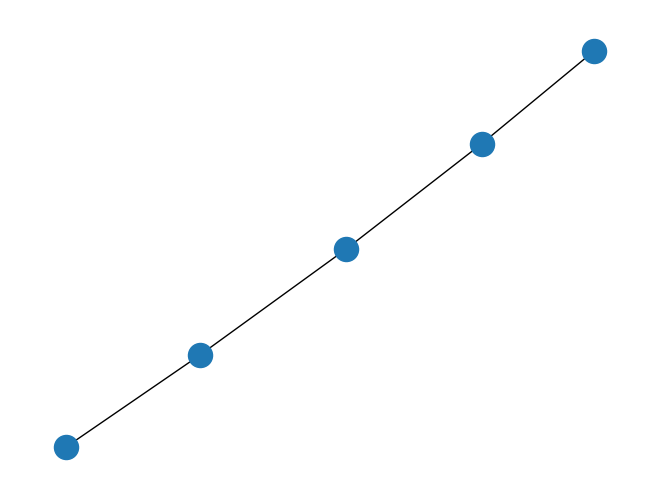

In [14]:
my_metadata = my_custom_device.metadata

# Display device graph:
nx.draw(my_metadata.nx_graph)

## Use in a virtual Engine

`Device`s can also be used to specify `cirq.SimulatedLocalEngine` instances, which let you validate and simulate circuits using the same interface that the quantum hardware does. Read more in the [Virtual Engine Interface](../simulate/virtual_engine_interface.ipynb) page. 

Additionally, these virtual `Engine`s can be combined with noisy simulation that attempts to mimic existing hardware devices with the [Quantum Virtual Machine](../simulate/quantum_virtual_machine.ipynb). 

# Summary

Devices in Cirq are used to specify constraints on circuits that are imposed by quantum hardware devices. You can check that an operation, moment, or circuit is valid on a particular `cirq.Device` by using `validate_operation`, `validate_moment`, or `validate_circuit` respectively. You can also create your own custom device objects to specify constraints for a new or changed device. Device objects, custom and otherwise, also can carry around metadata that may be useful for the validation process or other processes.